In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
from textwrap import wrap
from scipy.stats import ks_2samp

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [3]:
np.set_printoptions(precision=16)

## Load model weights and data

In [4]:
#sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
sys.path.append('../models/cWGAN/Run_2021-07-02_0/')
import cWGAN
#save_dir = '../models/cWGAN/Run_2021-03-21_0/'
save_dir = '../models/cWGAN/Run_2021-07-02_0/'
assert(os.path.isdir(save_dir))

In [5]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutFixRap.txt", skiprows=2)

In [6]:
normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

print(normalized_mean)
print(normalized_std)
print(reco_mean)
print(reco_std)

normalized_data = (normalized_data - normalized_mean) / normalized_std

[ 1.7325336127869422e+00 -4.3979818848981752e-03 -8.1989632208202834e-04
  2.0738273199892845e+00]
[0.2664415599646997 1.6109608763373062 1.813214019844585
 0.4007043722622637]
[ 1.6574159582302348e+00 -4.4009885497273684e-03 -5.8530799456628130e-04
  1.9991621188618929e+00]
[0.3107208060660628 1.609712071592146  1.8132994467877084
 0.4030490622744889]


In [7]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [8]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_435000')

In [48]:
# Save the model so it can be called from c++ code later
#tf.saved_model.save(cwgan.generator, save_dir + 'model')

## Make Predictions

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [16]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 5s, sys: 2.79 s, total: 1min 8s
Wall time: 2.37 s


In [17]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
predict[:, 3] = 10**predict[:, 3]

## Make Joint Distribution Plot

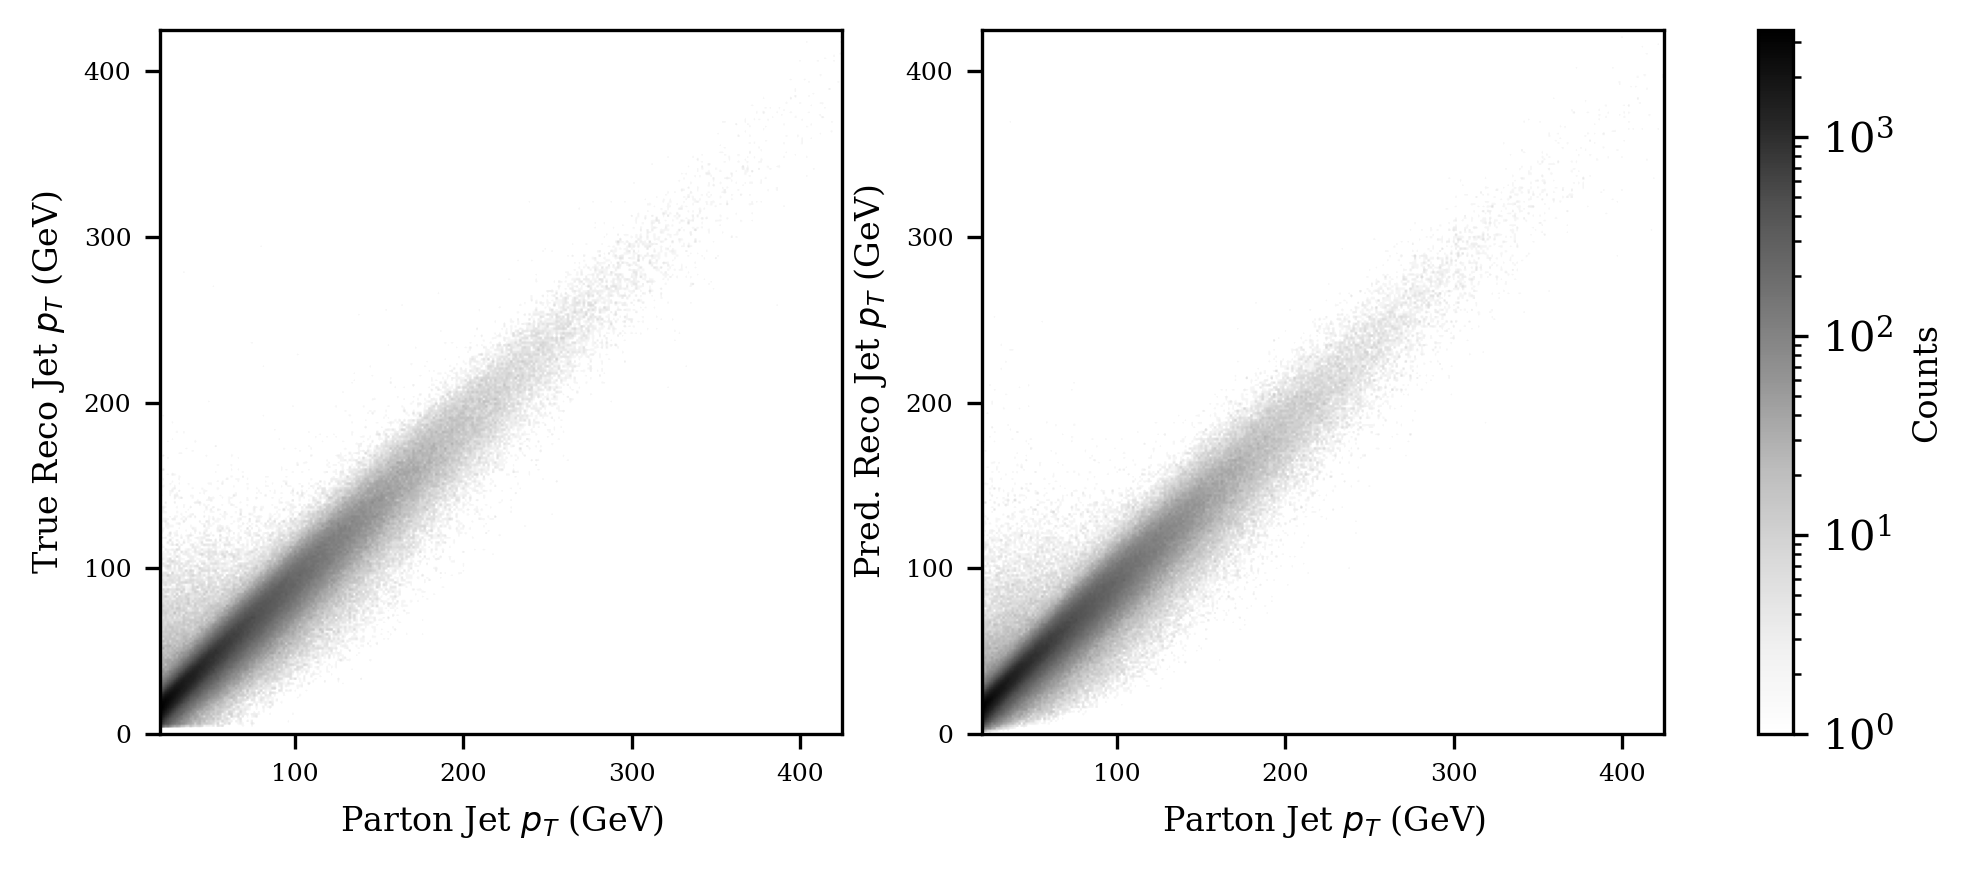

In [12]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
fig = plt.figure(figsize=(7,3), dpi=300)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 425
y_low = 0
y_hi = 425
num_bins=300
ytickvals = [0, 100, 200, 300, 400]
xtickvals = [100, 200, 300, 400]

h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax1.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=8)
ax1.set_ylabel(r"True Reco Jet $p_T$ (GeV)", size=8)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.set_yticks(ytickvals)
ax1.set_xticks(xtickvals)

#ax1.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and True Reco Jet $P_t$", width=40)), size=8)


z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
hist = ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys", norm=mcolors.LogNorm())
ax2.set_xlabel(r"Parton Jet $p_T$ (GeV)", size=8)
ax2.set_ylabel(r"Pred. Reco Jet $p_T$ (GeV)", size=8)
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_yticks(ytickvals)
ax2.set_xticks(xtickvals)
#ax2.set_yticks([0, 100, 200, 300, 400])
#ax2.set_title("\n".join(wrap(r"Joint Distribution of Parton Jet $P_t$ and Predicted Reco Jet $P_t$", width=40)), size=10)

#plt.xticks(fontsize=6)
#plt.yticks(fontsize=6)

plt.tight_layout()
cb = plt.colorbar(hist, ax=[ax1, ax2])
cb.set_label(label="Counts", size=8)
#plt.savefig('../data/plots/jointdistribution.png')
plt.show()

<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_diff = diff / h2
<ipython-input-28-fe3ec17cabef>:2: RuntimeWarning: invalid value encountered in true_divide
  rel_diff = diff / h2


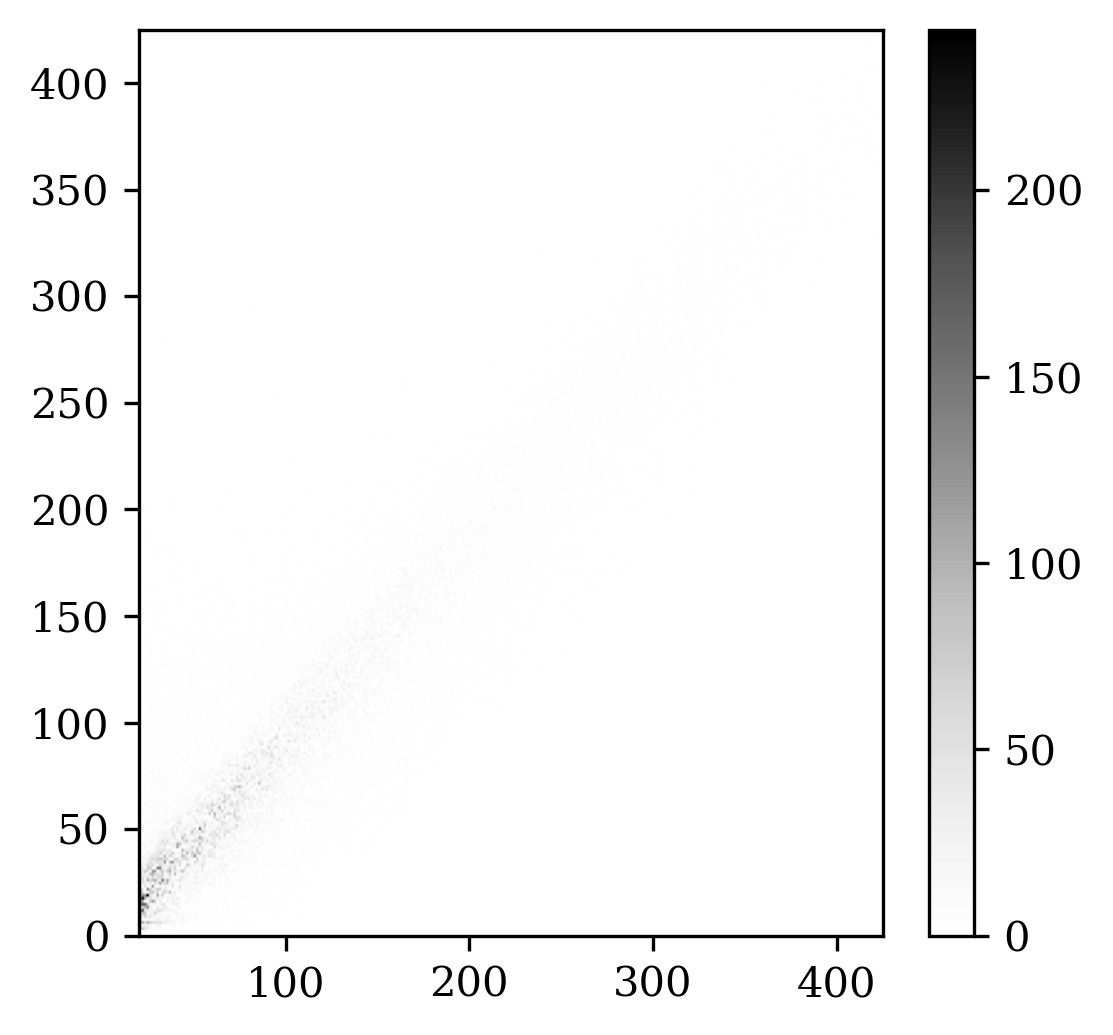

In [28]:
diff = np.abs(h2-z2)
rel_diff = diff / h2
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.add_subplot(111)
hist = ax.imshow(diff.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), cmap="Greys")#, norm=mcolors.LogNorm())
plt.colorbar(hist)
plt.show()


## Make Marginal Distribution Plots

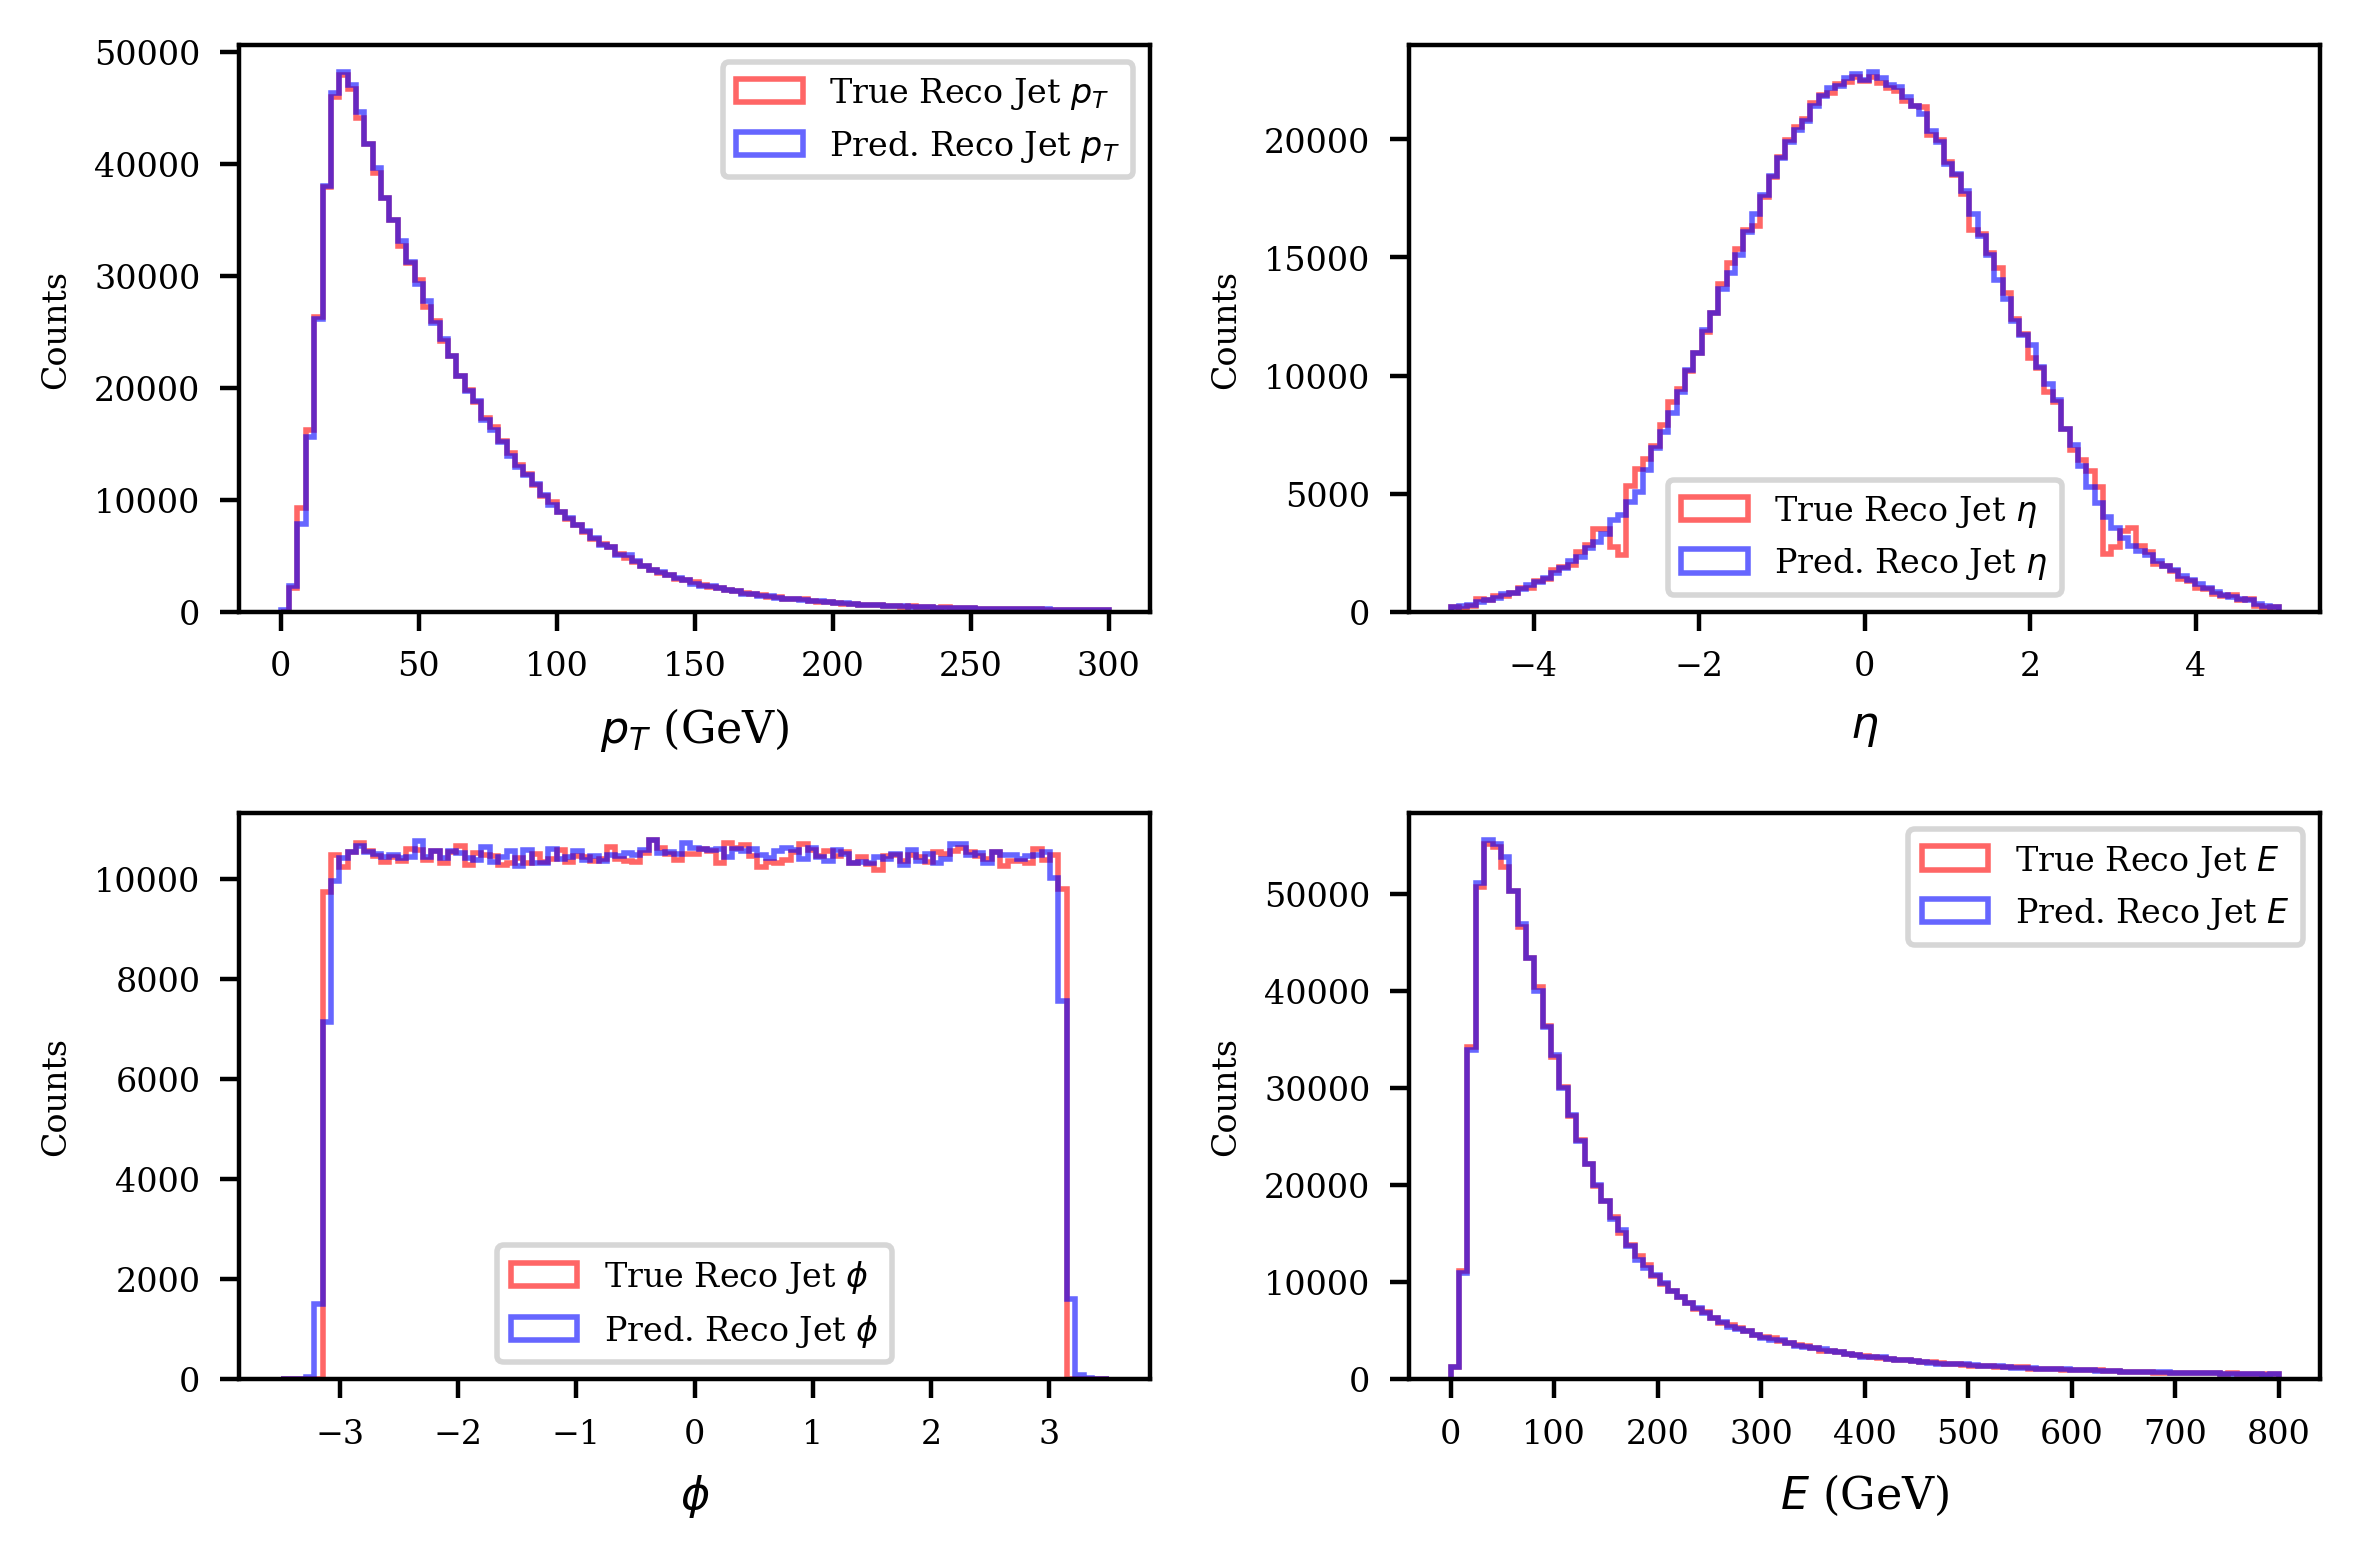

In [13]:
fig = plt.figure(figsize=(6,4), dpi=400)
bins = np.linspace(0, 300, 100)
ax1 = fig.add_subplot(221)
ax1.hist(data[:, 4], label=r"True Reco Jet $p_T$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax1.hist(predict[:, 0], label=r"Pred. Reco Jet $p_T$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax1.set_title(r"True and Predicted Marginal Reco Jet $P_t$ Distributions")
ax1.set_xlabel(r"$p_T$ (GeV)", size=8)
ax1.set_ylabel("Counts", size=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.legend(fontsize=6)

bins = np.linspace(-5, 5, 100)
ax2 = fig.add_subplot(222)
ax2.hist(data[:, 5], label=r"True Reco Jet $\eta$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax2.hist(predict[:, 1], label=r"Pred. Reco Jet $\eta$", bins=bins, alpha=0.6, ec="b", histtype='step')
#ax2.set_title(r"True and Predicted Marginal Reco Jet $\eta$ Distributions")
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.set_xlabel(r"$\eta$", size=8)
ax2.set_ylabel("Counts", size=6)
ax2.legend(loc='lower center', fontsize=6)

bins = np.linspace(-3.5, 3.5, 100)
ax3 = fig.add_subplot(223)
ax3.hist(data[:, 6], label=r"True Reco Jet $\phi$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax3.hist(predict[:, 2], label=r"Pred. Reco Jet $\phi$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax3.set_title(r"True and Predicted Marginal Jet $\phi$ Distributions")
ax3.tick_params(axis='x', labelsize=6)
ax3.tick_params(axis='y', labelsize=6)
ax3.set_xlabel(r"$\phi$", size=8)
ax3.set_ylabel("Counts", size=6)
ax3.legend(loc='lower center', fontsize=6)

bins = np.linspace(0, 800, 100)
ax4 = fig.add_subplot(224)
ax4.hist(data[:, 7], label=r"True Reco Jet $E$", bins=bins, alpha=0.6, ec="r", histtype='step')
ax4.hist(predict[:, 3], label=r"Pred. Reco Jet $E$", bins=bins, ec="b", alpha=0.6, histtype='step')
#ax4.set_title(r"True and Predicted Marginal Reco Jet Energy Distributions")
ax4.set_xlabel(r"$E$ (GeV)", size=8)
ax4.set_ylabel("Counts", size=6)
ax4.tick_params(axis='x', labelsize=6)
ax4.tick_params(axis='y', labelsize=6)
ax4.legend(fontsize=6)
plt.tight_layout()

plt.show()
#plt.savefig("../data/plots/marginalDists.pdf")

In [53]:
print(ks_2samp(data[:, 4], predict[:, 0]))
print(ks_2samp(data[:, 5], predict[:, 1]))
print(ks_2samp(data[:, 6], predict[:, 2]))
print(ks_2samp(data[:, 7], predict[:, 3]))
print(ks_2samp(predict[:, 0], data[:, 4], mode='asymp'))

KstestResult(statistic=0.0019246232291689758, pvalue=0.06396671312675173)
KstestResult(statistic=0.0024811278206010035, pvalue=0.006555142220033023)
KstestResult(statistic=0.002584463295992629, pvalue=0.0040304722168932605)
KstestResult(statistic=0.0032593731196441933, pvalue=0.0001032439934658096)
KstestResult(statistic=0.0019246232291689758, pvalue=0.06396671312675173)


KstestResult(statistic=0.01884301219648654, pvalue=2.5398982530302023e-07)
KstestResult(statistic=0.003650330981503136, pvalue=0.7108086978707474)
KstestResult(statistic=0.02392620351686365, pvalue=0.27383896266535823)
KstestResult(statistic=0.0449438202247191, pvalue=0.5555644903797275)


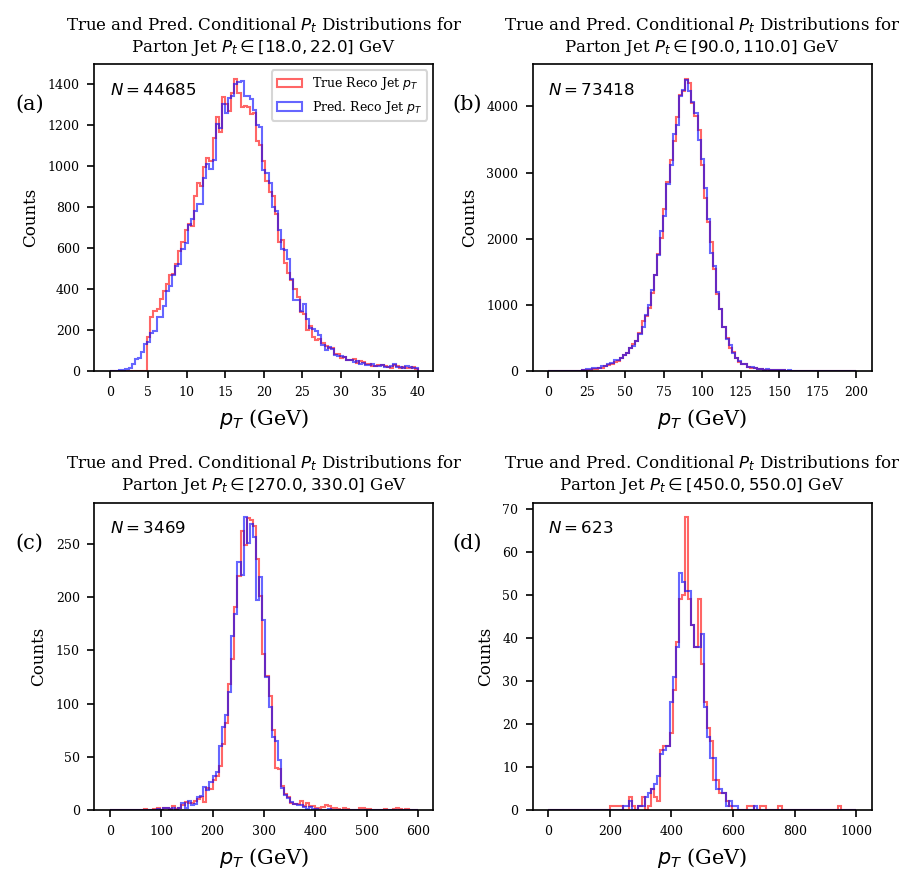

In [25]:
plt.rc('font', family='serif')
#range_highs = [40, 100, 200, 400, 600, 1000]
#range_lows = [0, 0, 0, 0, 0, 0, 0]
range_highs = [40, 200, 600, 1000]
range_lows = [0, 0, 0, 0, 0]
j = 0
nrow = 2; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(6,6), dpi=150)
ax = axs.flatten()
letters = ['(a)', '(b)', '(c)', '(d)']#, '(e)', '(f)']

#for center in [20, 50, 100, 200, 300, 500]:    
for center in [20, 100, 300, 500]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
        #if (len(recoPt) > 1400):
        #    break
    print(ks_2samp(recoPt, predPt))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    #fig = plt.figure(figsize=(6,4), dpi=100)
    #ax = fig.add_subplot(111)
    ax[j].hist(recoPt, bins=bins, label=r'True Reco Jet $p_T$', alpha=0.6, ec="r", histtype='step')
    ax[j].hist(predPt, bins=bins, label=r'Pred. Reco Jet $p_T$', alpha=0.6, ec="b", histtype='step')
    ax[j].text(0,0.9*ax[j].get_ylim()[1], r"$N={}$".format(len(recoPt)), size=8)
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    #if j==2 or j==3:
    ax[j].set_xlabel(r"$p_T$ (GeV)")
    ax[j].set_ylabel("Counts", size=8)
    ax[j].tick_params(axis='x', labelsize=6)
    ax[j].tick_params(axis='y', labelsize=6)
    #ax[j].set_ylabel("Count")
    #ax[j].set_title("Parton Jet $P_t =${} GeV".format(center), size=10)
    ax[j].set_title("\n".join(wrap(r"True and Pred. Conditional $P_t$ Distributions for Parton Jet $P_t \in [{}, {}]$ GeV".format(low, high), width=50)), fontsize=8)
    #ax.axvline(x=center/2)
    ax[j].text(-0.15, 0.9, letters[j], fontsize=10, transform=ax[j].transAxes, va='top', ha='right')
    if j ==0:
        ax[j].legend(fontsize=6)
    #fig.savefig("../data/plots/PtDistLog{}.pdf".format(j), facecolor="white", transparent="True")
    j+=1
#fig.suptitle(r"Conditional Reco $P_t$ Distributions")
plt.tight_layout()
#plt.savefig("../data/plots/ConditionalPtDistPres.pdf")
plt.show()



In [181]:
print(data[57, :])
#print(normalized_data[6, :])

[165.588      0.816852  -0.638159 224.319    148.319      0.81323
  -0.640312 201.094   ]


In [124]:
same_point1 = np.zeros((500000, 4))
same_point2 = np.zeros((500000, 4))
same_point3 = np.zeros((500000, 4))
same_point4 = np.zeros((500000, 4))
same_point5 = np.zeros((500000, 4))
same_point6 = np.zeros((500000, 4))
same_point7 = np.zeros((500000, 4))
same_point8 = np.zeros((500000, 4))

In [125]:
for i in range(len(same_point)):
    same_point1[i, :] = normalized_data[0, :]
    same_point2[i, :] = normalized_data[6, :]
    same_point3[i, :] = normalized_data[10, :]
    same_point4[i, :] = normalized_data[12, :]
    same_point5[i, :] = normalized_data[9, :]
    same_point6[i, :] = normalized_data[14, :]
    same_point7[i, :] = normalized_data[36, :]
    same_point8[i, :] = normalized_data[57, :]

In [126]:
repeat_predict1 = np.array(cwgan.make_generator_predictions(same_point1))
repeat_predict1 = repeat_predict1 * reco_std + reco_mean
repeat_predict1[:, 0] = 10**repeat_predict1[:, 0]
repeat_predict1[:, 3] = 10**repeat_predict1[:, 3]

repeat_predict2 = np.array(cwgan.make_generator_predictions(same_point2))
repeat_predict2 = repeat_predict2 * reco_std + reco_mean
repeat_predict2[:, 0] = 10**repeat_predict2[:, 0]
repeat_predict2[:, 3] = 10**repeat_predict2[:, 3]

repeat_predict3 = np.array(cwgan.make_generator_predictions(same_point3))
repeat_predict3 = repeat_predict3 * reco_std + reco_mean
repeat_predict3[:, 0] = 10**repeat_predict3[:, 0]
repeat_predict3[:, 3] = 10**repeat_predict3[:, 3]

repeat_predict4 = np.array(cwgan.make_generator_predictions(same_point4))
repeat_predict4 = repeat_predict4 * reco_std + reco_mean
repeat_predict4[:, 0] = 10**repeat_predict4[:, 0]
repeat_predict4[:, 3] = 10**repeat_predict4[:, 3]

repeat_predict5 = np.array(cwgan.make_generator_predictions(same_point5))
repeat_predict5 = repeat_predict5 * reco_std + reco_mean
repeat_predict5[:, 0] = 10**repeat_predict5[:, 0]
repeat_predict5[:, 3] = 10**repeat_predict5[:, 3]

repeat_predict6 = np.array(cwgan.make_generator_predictions(same_point6))
repeat_predict6 = repeat_predict6 * reco_std + reco_mean
repeat_predict6[:, 0] = 10**repeat_predict6[:, 0]
repeat_predict6[:, 3] = 10**repeat_predict6[:, 3]

repeat_predict7 = np.array(cwgan.make_generator_predictions(same_point7))
repeat_predict7 = repeat_predict7 * reco_std + reco_mean
repeat_predict7[:, 0] = 10**repeat_predict7[:, 0]
repeat_predict7[:, 3] = 10**repeat_predict7[:, 3]

repeat_predict8 = np.array(cwgan.make_generator_predictions(same_point8))
repeat_predict8 = repeat_predict8 * reco_std + reco_mean
repeat_predict8[:, 0] = 10**repeat_predict8[:, 0]
repeat_predict8[:, 3] = 10**repeat_predict8[:, 3]

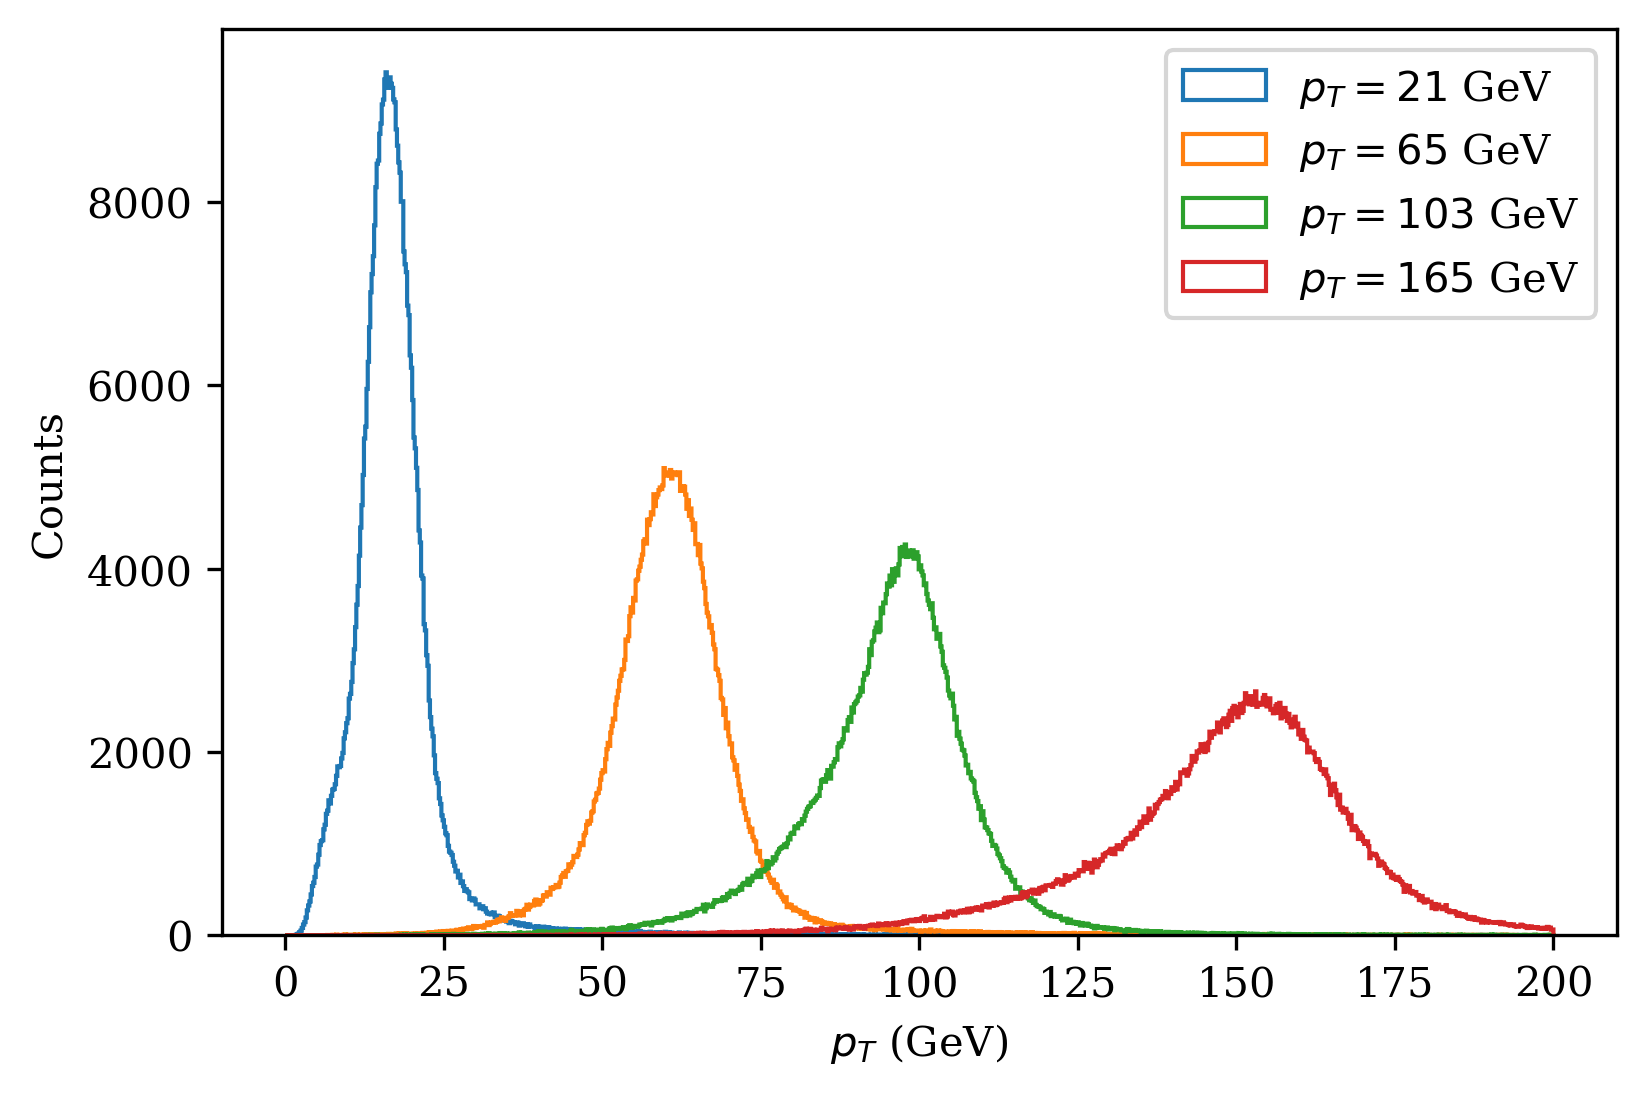

In [182]:
fig = plt.figure(figsize=(6, 4), dpi=300)
ax = fig.add_subplot(111) 
bins = np.linspace(0, 200, 1000)
#ax.hist(repeat_predict1[:, 0], bins=bins, histtype='step')

#ax.hist(repeat_predict3[:, 0], bins=bins, histtype='step')
ax.hist(repeat_predict4[:, 0], bins=bins, histtype='step', label=r'$p_T = 21$ GeV')
#ax.hist(repeat_predict5[:, 0], bins=bins, histtype='step')
#ax.hist(repeat_predict6[:, 0], bins=bins, histtype='step')
ax.hist(repeat_predict7[:, 0], bins=bins, histtype='step', label=r'$p_T = 65$ GeV')
ax.hist(repeat_predict2[:, 0], bins=bins, histtype='step', label=r'$p_T = 103$ GeV')
ax.hist(repeat_predict8[:, 0], bins=bins, histtype='step', label=r'$p_T = 165$ GeV')
#ax.set_title(r"Distribution of 500,000 simulations of one jet with $p_t = 103$ GeV.")
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Counts")
ax.legend()
plt.savefig("../data/plots/repeatedDists.pdf")
plt.show()

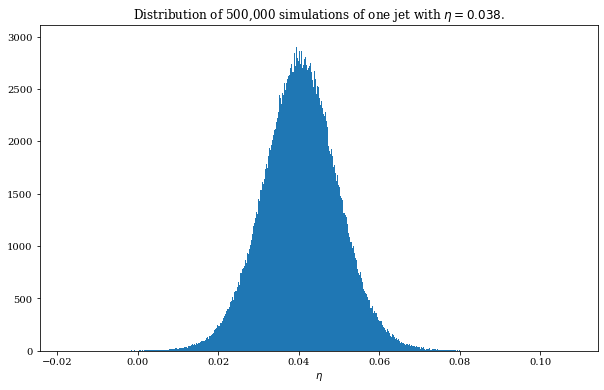

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 1], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\eta = 0.038$.")
ax.set_xlabel(r"$\eta$")
plt.show()

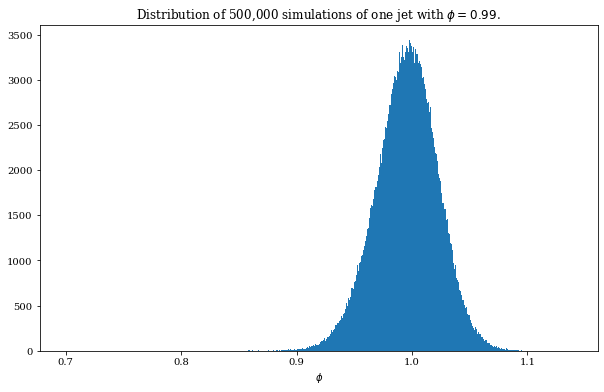

In [19]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 2], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $\phi = 0.99$.")
ax.set_xlabel(r"$\phi$")
plt.show()

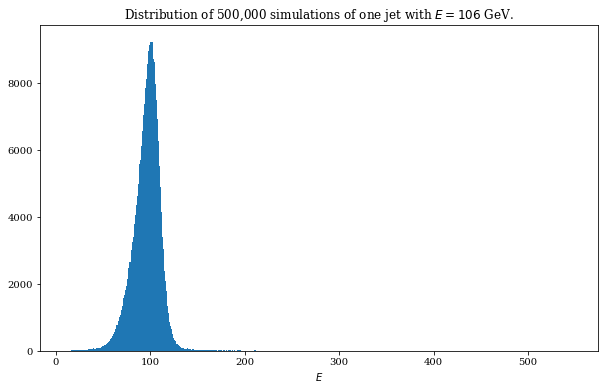

In [20]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111) 
ax.hist(repeat_predict[:, 3], bins=1000)
ax.set_title(r"Distribution of 500,000 simulations of one jet with $E = 106$ GeV.")
ax.set_xlabel(r"$E$")
plt.show()